In [1]:
%matplotlib widget 
#widget
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from IPython.display import display
import os
from help_func_new_paradigm import *
from mne.time_frequency import tfr_array_morlet

In [2]:
from help_func_new_paradigm import *

In [3]:
method= "A1"
feature_types=["B3"]

In [4]:
# Load the signal recording data
base_path = Path.cwd().parent  / "data"/ "ali_paradigm_training" 
df_eeg= pd.read_csv(base_path /'19.07.1.csv')

C:\Users\acer\AppData\Local\Temp\ipykernel_19580\2123665483.py:3: DtypeWarning: Columns (16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eeg= pd.read_csv(base_path /'19.07.1.csv')


In [5]:
df_annotated = annotate_flash_and_target_columns(df_eeg)
df_with_trials = add_trial_count_column_for_flashes_only(df_annotated)

# Spatiotemporal ERC

In [6]:
df_single = epoch_grouped_trialwise_average(df_with_trials, normalization=method, 
                                                        blink_threshold=120, blink_rejection=True)

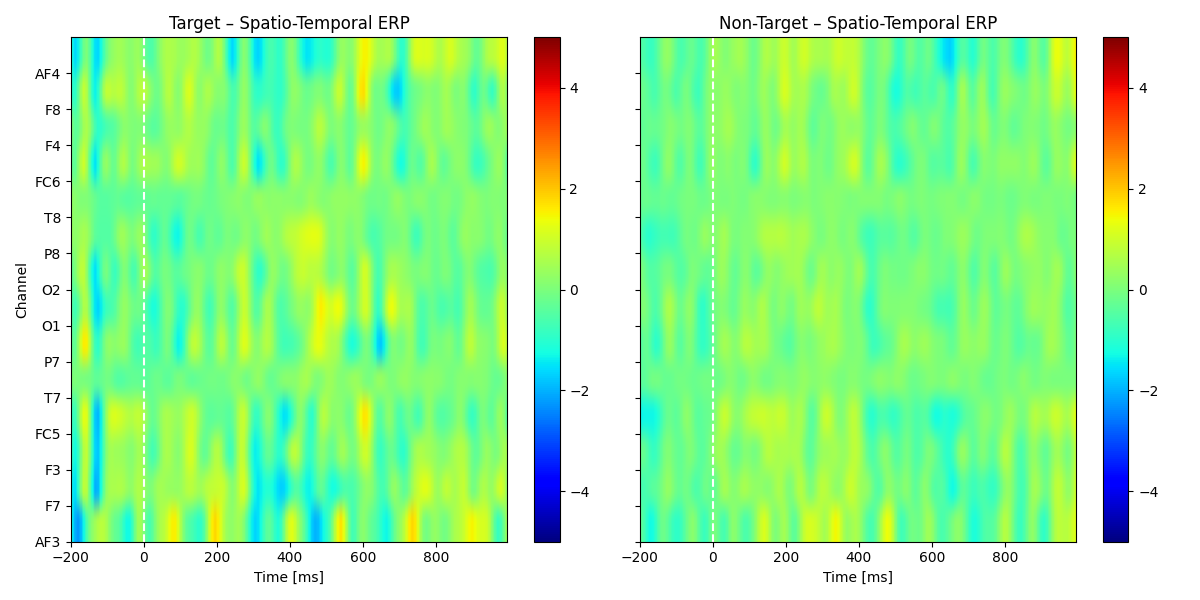

In [7]:
# Define channel order
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

fs = 128
tmin = -0.2
epoch_len = len(df_single[channel_names[0]].iloc[0])
time_ms = np.linspace(tmin * 1000, (tmin + epoch_len / fs) * 1000, epoch_len)

# Helper: extract mean ERP (channel × time)
def compute_spatiotemporal_average(df_group):
    erp = []
    for ch in channel_names:
        stacked = np.stack(df_group[ch].values)  # shape: (n_trials, time)
        avg = stacked.mean(axis=0)               # shape: (time,)
        erp.append(avg)
    return np.array(erp)  # shape: (channels, time)

# Group and compute
erp_target = compute_spatiotemporal_average(df_single[df_single["is_target"] == 1])
erp_nontarget = compute_spatiotemporal_average(df_single[df_single["is_target"] == 0])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

im0 = axes[0].imshow(erp_target, aspect='auto', cmap='jet',
                     extent=[time_ms[0], time_ms[-1], 0, len(channel_names)],
                     vmin=-5, vmax=5)
axes[0].set_title("Target – Spatio-Temporal ERP")
axes[0].set_xlabel("Time [ms]")
axes[0].set_ylabel("Channel")
axes[0].set_yticks(np.arange(len(channel_names)))
axes[0].set_yticklabels(channel_names)
axes[0].axvline(0, color='white', linestyle='--')
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(erp_nontarget, aspect='auto', cmap='jet',
                     extent=[time_ms[0], time_ms[-1], 0, len(channel_names)],
                     vmin=-5, vmax=5)
axes[1].set_title("Non-Target – Spatio-Temporal ERP")
axes[1].set_xlabel("Time [ms]")
axes[1].set_yticks(np.arange(len(channel_names)))
axes[1].set_yticklabels(channel_names)
axes[1].axvline(0, color='white', linestyle='--')
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


# Complex Wavelet transform

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


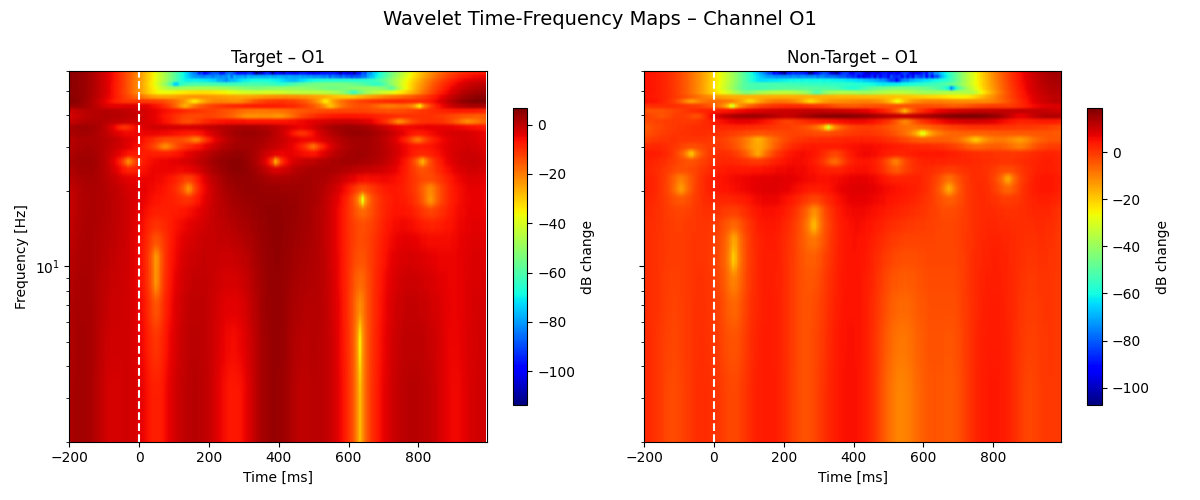

In [8]:
# -------------------------------------------
# Parameters
# -------------------------------------------
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
selected_channel = 'O1'      # Choose an available channel
sfreq = 128                  # Sampling frequency in Hz
tmin = -0.2                  # Start of epoch in seconds
frequencies = np.logspace(np.log10(2), np.log10(60), 30)  # 2–60 Hz log scale
n_cycles = frequencies / 2.  # Frequency-dependent cycles
# -------------------------------------------

# -------------------------------------------
# Get average signals for target and non-target
# -------------------------------------------
target_epochs = df_single[df_single["is_target"] == 1][selected_channel].values
nontarget_epochs = df_single[df_single["is_target"] == 0][selected_channel].values

# Average across trials
X_target = np.mean(np.stack(target_epochs), axis=0)   # (n_times,)
X_nontarget = np.mean(np.stack(nontarget_epochs), axis=0)  # (n_times,)

# Reshape to match expected input: (n_epochs=1, n_channels=1, n_times)
X_target = X_target[np.newaxis, np.newaxis, :]
X_nontarget = X_nontarget[np.newaxis, np.newaxis, :]

# Time vector for plotting (in ms)
n_times = X_target.shape[-1]
times = np.linspace(tmin * 1000, (tmin + n_times / sfreq) * 1000, n_times)
# -------------------------------------------

# -------------------------------------------
# Wavelet Transform for both conditions
# -------------------------------------------
power_target = tfr_array_morlet(X_target, sfreq=sfreq, freqs=frequencies,
                                n_cycles=n_cycles, output='power')[0, 0]

power_nontarget = tfr_array_morlet(X_nontarget, sfreq=sfreq, freqs=frequencies,
                                   n_cycles=n_cycles, output='power')[0, 0]

# Baseline correction: compute dB change from pre-stimulus
baseline_mask = times < 0
baseline_target = power_target[:, baseline_mask].mean(axis=1, keepdims=True)
baseline_nontarget = power_nontarget[:, baseline_mask].mean(axis=1, keepdims=True)

power_target_dB = 10 * np.log10(power_target / baseline_target)
power_nontarget_dB = 10 * np.log10(power_nontarget / baseline_nontarget)
# -------------------------------------------

# -------------------------------------------
# Plot both as subplots
# -------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Target plot
im0 = axes[0].imshow(power_target_dB, aspect='auto', cmap='jet',
                     extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
                     origin='lower')
axes[0].set_title(f"Target – {selected_channel}")
axes[0].set_xlabel("Time [ms]")
axes[0].set_ylabel("Frequency [Hz]")
axes[0].axvline(0, color='white', linestyle='--')
axes[0].set_yscale('log')
fig.colorbar(im0, ax=axes[0], label='dB change', shrink=0.8)

# Non-target plot
im1 = axes[1].imshow(power_nontarget_dB, aspect='auto', cmap='jet',
                     extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
                     origin='lower')
axes[1].set_title(f"Non-Target – {selected_channel}")
axes[1].set_xlabel("Time [ms]")
axes[1].axvline(0, color='white', linestyle='--')
axes[1].set_yscale('log')
fig.colorbar(im1, ax=axes[1], label='dB change', shrink=0.8)

plt.suptitle(f"Wavelet Time-Frequency Maps – Channel {selected_channel}", fontsize=14)
plt.tight_layout()
plt.show()


# ERP Image - Don't work as Our data sucks

In [9]:
def extract_epochs_df_from_long_format(df, fs=128, tmin=-0.2, tmax=1.0, marker_col="which_one"):
    """
    Extract epochs from long-format EEG DataFrame based on flash events.

    Parameters
    ----------
    df : pd.DataFrame
        Long-form EEG DataFrame (each row = 1 time point).
    fs : int
        Sampling frequency (Hz).
    tmin : float
        Seconds before event marker to include in epoch.
    tmax : float
        Seconds after event marker to include in epoch.
    marker_col : str
        Column indicating which flashes occurred.

    Returns
    -------
    df_epochs : pd.DataFrame
        Columns: 'epoch' (time x channels), 'trial_count', 'which_one', 'is_target'
    """
    import numpy as np
    import pandas as pd

    # Epoch length in samples
    epoch_offsets = np.arange(int(tmin * fs), int(tmax * fs))  # e.g., -0.2s to 1.0s
    epoch_len = len(epoch_offsets)

    # Get EEG channels automatically (all float-like except metadata)
    exclude_cols = {'Time:128Hz', 'Epoch', 'Event Id', 'Event Date', 'Event Duration',
                    'is_target', 'which_one', 'trial_count'}
    eeg_cols = [col for col in df.columns if col not in exclude_cols and np.issubdtype(df[col].dtype, np.number)]

    print(f"Using EEG channels: {eeg_cols}")
    print(f"Epoch window: {tmin}s to {tmax}s → {epoch_len} samples")

    records = []
    for idx, row in df.iterrows():
        marker_val = row[marker_col]
        if isinstance(marker_val, str) and ("row" in marker_val.lower() or "column" in marker_val.lower()):
            try:
                # Create range of indices for this epoch
                indices = idx + epoch_offsets
                if indices.min() < 0 or indices.max() >= len(df):
                    continue  # skip out-of-bounds

                epoch = df.loc[indices, eeg_cols].to_numpy()
                records.append({
                    "epoch": epoch,
                    "trial_count": row["trial_count"],
                    "which_one": row["which_one"],
                    "is_target": row["is_target"]
                })
            except Exception as e:
                print(f"Skipping idx {idx} due to error: {e}")
                continue

    return pd.DataFrame(records)


Using EEG channels: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
Epoch window: -0.2s to 1.0s → 153 samples


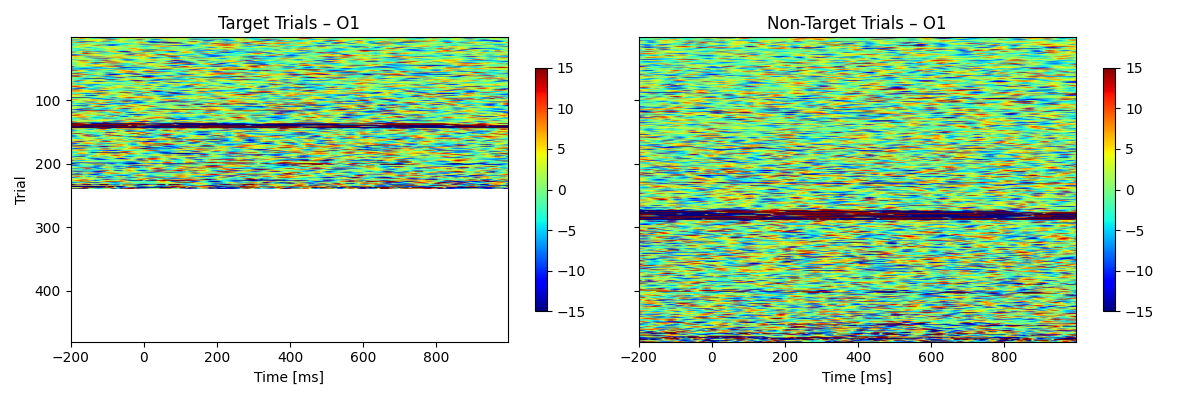

In [10]:
df_epochs = extract_epochs_df_from_long_format(df_with_trials)
# --- CONFIG ---
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_to_plot = 'O1'
channel_idx = channel_names.index(channel_to_plot)
fs = 128
tmin = -0.2  # seconds before stimulus

# --- EPOCH EXTRACTION ---
epochs_all = np.stack(df_epochs['epoch'].values)  # shape: (n_trials, time, channels)
is_target_all = df_epochs['is_target'].values

# Select channel and group
epochs_target = epochs_all[is_target_all == 1, :, channel_idx]
epochs_nontarget = epochs_all[is_target_all == 0, :, channel_idx]


# --- Time vector ---
n_time = epochs_target.shape[1]
time_ms = np.linspace(tmin * 1000, (tmin + n_time / fs) * 1000, n_time)

# --- Baseline correction (-200 to 0 ms) ---
baseline_samples = np.where(time_ms < 0)[0]
epochs_target -= epochs_target[:, baseline_samples].mean(axis=1, keepdims=True)
epochs_nontarget -= epochs_nontarget[:, baseline_samples].mean(axis=1, keepdims=True)

# --- Demean over full epoch (optional, improves display) ---
epochs_target -= epochs_target.mean(axis=1, keepdims=True)
epochs_nontarget -= epochs_nontarget.mean(axis=1, keepdims=True)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

im0 = axes[0].imshow(epochs_target, aspect='auto', cmap='jet',
                     extent=[time_ms[0], time_ms[-1], 1, epochs_target.shape[0]],
                     vmin=-15, vmax=15)
axes[0].set_title(f"Target Trials – {channel_to_plot}")
axes[0].set_xlabel("Time [ms]")
axes[0].set_ylabel("Trial")
axes[0].invert_yaxis()
fig.colorbar(im0, ax=axes[0], shrink=0.8)

im1 = axes[1].imshow(epochs_nontarget, aspect='auto', cmap='jet',
                     extent=[time_ms[0], time_ms[-1], 1, epochs_nontarget.shape[0]],
                     vmin=-15, vmax=15)
axes[1].set_title(f"Non-Target Trials – {channel_to_plot}")
axes[1].set_xlabel("Time [ms]")
axes[1].invert_yaxis()
fig.colorbar(im1, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()



In [11]:
print("Min:", np.min(epochs_target))
print("Max:", np.max(epochs_target))
print("Unique values (rounded):", np.unique(epochs_target.round(1)))


Min: -2468.503426308151
Max: 3758.824957072145
Unique values (rounded): [-2468.5 -2466.2 -2365.4 ...  3603.   3626.7  3758.8]
